# Find Noisy Labels in Regression Datasets

This 5-minute quickstart tutorial uses cleanlab to find potentially incorrect numeric values in a dataset column by means of a regression model. Unlike classification models, regression predicts continuous quantities such as price, income, age,... Here we consider a Grades dataset, which records three exam grades and some optional notes for over 900 students, each being assigned a final score. Combined with any regression model of your choosing, cleanlab automatically identifies examples in this dataset that have incorrect final scores.

**Overview of what we’ll do in this tutorial:**

- Fit a simple Gradient Boosting model (any other model could be used) on the exam-score and notes (covariates) in order to compute out-of-sample predictions of the final grade (the response variable in our regression).
- Use cleanlab's `CleanLearning.find_label_issues()` method to identify potentially incorrect final grade values based on outputs from this regression model.
- Train a more robust version of the same model after dropping the identified label errors using CleanLearning.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have an sklearn-compatible regression `model`, features/covariates `X`, and a label/target variable `y`? Run the code below to train your `model` and identify potentially incorrect `y` values in your dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.regression.learn import CleanLearning

cl = CleanLearning(model)
cl.fit(X, y)
label_issues = cl.get_label_issues()
preds = cl.predict(X_test)  # predictions from a version of your model trained on auto-cleaned data
```
    
</div>
    
Is your model/data not compatible with `CleanLearning`? You can instead run cross-validation on your model to get out-of-sample `predictions`. Then run the code below to get label issue indices ranked by their inferred severity.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.regression.rank import get_label_quality_scores
 
label_quality_scores = get_label_quality_scores(y, predictions)
   
```
    
</div>
</div>

## 1. Install required dependencies

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install scikit-learn
!pip install cleanlab
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
# Package versions we used: scikit-learn

dependencies = ["cleanlab", "sklearn"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = " ".join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

from cleanlab.regression.learn import CleanLearning

In [3]:
# This cell is hidden from docs.cleanlab.ai 

import random 
import numpy as np 

SEED = 111 # for reproducibility 

np.random.seed(SEED)
random.seed(SEED)

## 2. Load and process the data

In [4]:
train_data = pd.read_csv("https://s.cleanlab.ai/student_grades_r/train.csv")
test_data = pd.read_csv("https://s.cleanlab.ai/student_grades_r/test.csv")
train_data.head()

,exam_1,exam_2,exam_3,notes,final_score,true_final_score
0,72,81,80,NaN,73.3,73.3
1,89,62,93,NaN,83.8,83.8
2,97,0,94,NaN,73.5,73.5
3,80,76,96,missed class frequently -10,78.6,78.6
4,67,87,95,missed homework frequently -10,74.1,74.1


In the DataFrame above, `final_score` represents the noisy scores and `true_final_score` represents the ground truth. Note that ground truth is usually not available in real-world datasets, and is added in this dataset for comparison and demonstration purposes.

We show a 3D scatter plot of the exam grades, with the color hue corresponding to the final score for each student. Incorrect datapoints are marked with an **X**.

<details><summary>See the code to visualize the data. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_data(train_data, errors_idx):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = train_data["exam_1"], train_data["exam_2"], train_data["exam_3"]
    labels = train_data["final_score"]

    img = ax.scatter(x, y, z, c=labels, cmap="jet")
    fig.colorbar(img)

    ax.plot(
        x.iloc[errors_idx],
        y.iloc[errors_idx],
        z.iloc[errors_idx],
        "x",
        markeredgecolor="black",
        markersize=10,
        markeredgewidth=2.5,
        alpha=0.8,
        label="Label Errors"
    )
    ax.legend()
```
    
</details>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_data(train_data, errors_idx):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = train_data["exam_1"], train_data["exam_2"], train_data["exam_3"]
    labels = train_data["final_score"]

    img = ax.scatter(x, y, z, c=labels, cmap="jet")
    fig.colorbar(img)

    ax.plot(
        x.iloc[errors_idx],
        y.iloc[errors_idx],
        z.iloc[errors_idx],
        "x",
        markeredgecolor="black",
        markersize=10,
        markeredgewidth=2.5,
        alpha=0.8,
        label="Label Errors"
    )
    ax.legend()

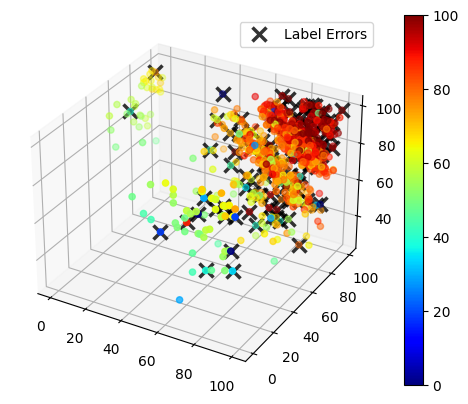

In [6]:
errors_mask = train_data["final_score"] != train_data["true_final_score"]
errors_idx = np.where(errors_mask == 1)

plot_data(train_data, errors_idx)

Next we preprocess the data by applying one-hot encoding to features with categorical data (this is optional if your regression model can work directly with categorical features).

In [7]:
feature_columns = ["exam_1", "exam_2", "exam_3", "notes"]
predicted_column = "final_score"

X_train_raw, y_train = train_data[feature_columns], train_data[predicted_column]
X_test_raw, y_test = test_data[feature_columns], test_data[predicted_column]

In [8]:
categorical_features = ["notes"]
X_train = pd.get_dummies(X_train_raw, columns=categorical_features)
X_test = pd.get_dummies(X_test_raw, columns=categorical_features)

<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

Assign your data's features to variable `X` and the target values to variable `y` instead, then continue with the rest of the tutorial.

</div>

## 3. Define a regression model and use cleanlab to find potential label errors

`CleanLearning` provides a wrapper class that can easily be applied to any scikit-learn compatible model, which can be used to find potential label issues and train a more robust model if the original data contains noisy labels.

Here we define a `CleanLearning` object with a simple  histogram-based gradient boosting model (similar to XGBoost) model and use `find_label_issues` to identify potential errors in our dataset's numeric label column (any other sklearn-compatible regression model could be used such as LinearRegression or RandomForestRegressor)

In [9]:
model = HistGradientBoostingRegressor()
cl = CleanLearning(model)

In [10]:
label_issues = cl.find_label_issues(X_train, y_train)

`CleanLearning` fits multiple copies of our regression model via cross-validation and bootstrapping in order to compute predictions and uncertainty estimates for the dataset, which are used to identify confident label issues.

This method returns a dataframe containing a label quality score for each example. These numeric scores lie between 0 and 1, where lower scores indicate examples more likely to be mislabeled with an erroneous `y` value. The dataframe also contains a boolean column specifying whether or not each example is identified to have a label issue (indicating it is likely mislabeled). 

In [11]:
label_issues.head()

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.641297,73.3,76.521450
1,False,0.955740,83.8,83.547234
2,False,0.331132,73.5,62.754531
3,False,0.623980,78.6,75.312295
4,False,0.766556,74.1,75.784048


We can get the subset of examples flagged with label issues, and also sort by label quality score to find the indices of the 10 most likely mislabeled examples in our dataset.

In [12]:
identified_issues = label_issues[label_issues["is_label_issue"] == True]
lowest_quality_labels = label_issues["label_quality"].argsort()[:10].to_numpy()

In [13]:
print(
    f"cleanlab found {len(identified_issues)} potential label errors in the dataset.\n"
    f"Here are indices of the top 10 most likely errors: \n {lowest_quality_labels}"
)

cleanlab found 113 potential label errors in the dataset.
Here are indices of the top 10 most likely errors: 
 [659 367  56 560 289 318 305 657 688 117]


Let’s review some of the most likely label errors. To help us inspect these datapoints, we define a method to print any example from the dataset, together with its given (original) label and the suggested alternative label from cleanlab.

In [14]:
def view_datapoint(index):
    given_labels = label_issues["given_label"]
    predicted_labels = label_issues["predicted_label"].round(1)
    return pd.concat(
        [X_train_raw, given_labels, predicted_labels], axis=1
    ).iloc[index]

In [15]:
view_datapoint(lowest_quality_labels[:5])

,exam_1,exam_2,exam_3,notes,given_label,predicted_label
659,67,93,93,NaN,17.4,85.2
367,78,0,86,NaN,0.0,56.5
56,75,83,69,NaN,8.9,70.8
560,95,0,72,NaN,0.0,55.4
289,78,53,96,missed homework frequently -10,27.1,66.7


These are very clear errors that cleanlab has identified in this data! Note that the `given_label` does not correctly reflect the final grade that these student should be getting. 

cleanlab has shortlisted the most likely label errors to speed up your data cleaning process. With this list, you can decide whether to fix these label issues or remove erroneous examples from the dataset.

## 4. Train a more robust model from noisy labels

Fixing the label issues manually may be time-consuming, but cleanlab can filter these noisy examples and train a model on the remaining clean data for you automatically.

To establish a baseline, let’s first train and evaluate our original Gradient Boosting model.

In [16]:
baseline_model = HistGradientBoostingRegressor()  
baseline_model.fit(X_train, y_train)

preds_og = baseline_model.predict(X_test)
r2_og = r2_score(y_test, preds_og)
print(f"r-squared score of original model: {r2_og:.3f}")

r-squared score of original model: 0.838


Now that we have a baseline, let’s check if using `CleanLearning` improves our test accuracy.

`CleanLearning` provides a wrapper that can be applied to any scikit-learn compatible model. The resulting model object can be used in the same manner, but it will now train more robustly if the data has noisy labels.

We can use the same `CleanLearning` object defined above, and pass the label issues we already computed into `.fit()` via the `label_issues` argument. This accelerates things; if we did not provide the label issues, then they would be recomputed via cross-validation. After that `CleanLearning` simply removesb the examples with label issues and retrains your model on the remaining data.

In [17]:
found_label_issues = cl.get_label_issues()
cl.fit(X_train, y_train, label_issues=found_label_issues)

preds_cl = cl.predict(X_test)
r2_cl = r2_score(y_test, preds_cl)
print(f"r-squared score of cleanlab's model: {r2_cl:.3f}")

r-squared score of cleanlab's model: 0.918


We can see that the coefficient of determination (r-squared score) of the test set improved as a result of the data cleaning. Note that this will not always be the case, especially when we are evaluating on test data that are themselves noisy. The best practice is to run cleanlab to identify potential label issues and then manually review them, before blindly trusting any evaluation metrics. In particular, the most effort should be made to ensure high-quality test data, which is supposed to reflect the expected performance of our model during deployment.

## 5. Other workflows to find label issues in regression datasets

The `CleanLearning` workflow above requires a sklearn-compatible model, if your model or data format is not compatible with the requirements for using `CleanLearning`, you can instead run cross-validation on your model to get out-of-sample predictions, then use the `cleanlab.regression.rank.get_label_quality_scores` method to obtain label quality scores for each example.

This method only requires two inputs:

- `labels`: numpy array of given labels in the dataset. 
- `predictions`: numpy array of predictions generated through your favorite model.

In [18]:
# get predictions using cross-validation
model = HistGradientBoostingRegressor()
predictions = cross_val_predict(estimator=model, X=X_train, y=y_train)

In [19]:
from cleanlab.regression.rank import get_label_quality_scores

label_quality_scores = get_label_quality_scores(labels=y_train, predictions=predictions)
label_quality_scores[:5]

array([3.64404888e-02, 3.06755306e-01, 3.05302732e-04, 2.66635743e-01,
       2.53166364e-01])

These label quality scores are continuous values in the range [0,1] where 1 represents a clean label (given label is likely correct) and 0 a represents dirty label (given label appears likely incorrect). You can sort examples by their label quality scores to inspect the most-likely corrupted datapoints.

In [20]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
from sklearn.metrics import roc_auc_score

if r2_cl <= r2_og:
    raise ValueError("CleanLearning did not improve r2 score")

label_quality_score_cl = label_issues["label_quality"]
label_quality_scores_residual = get_label_quality_scores(labels=y_train, predictions=predictions, method="residual")

auc_outre = roc_auc_score(errors_mask, 1 - label_quality_scores)
auc_cl = roc_auc_score(errors_mask, 1 - label_quality_score_cl)
auc_residual = roc_auc_score(errors_mask, 1 - label_quality_scores_residual)

if auc_outre <= 0.5 or auc_cl <= 0.5:
    raise ValueError("Label quality scores did not perform well enough")

if auc_outre <= auc_residual:
    raise ValueError("Outre label quality scores did not outperform alternative scores")
    
if auc_cl <= auc_residual:
    raise ValueError("CL label quality scores did not outperform alternative scores")